In [28]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tabulate
import pandas as pd
from colorama import init, Fore, Back, Style
from tabulate import tabulate
from colorama import Fore, Style

# Initialize colorama for colored output
init(autoreset=True)

# Import our custom modules
import image_processing as ip
import feature_extraction as fe
import utils
import config

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

# PH2 Dataset Configuration
sample_image_path = r"C:\Users\Aakarsh Goyal\Downloads\archive\PH2Dataset\PH2 Dataset images\IMD427\IMD427_Dermoscopic_Image\IMD427.bmp" 
ground_truth_mask_path = r"C:\Users\Aakarsh Goyal\Downloads\archive\PH2Dataset\PH2 Dataset images\IMD427\IMD427_lesion\IMD427_lesion.bmp" 

## Pipeline Overview:
1. **Image Loading & Preprocessing**: Load, resize, and convert color spaces
2. **Hair Removal**: Remove artifacts using Black Hat technique & Inpainting (TELEA)
3. **Lesion Segmentation**: Extract lesion using CIELab color space analysis
4. **Feature Extraction**: Calculate ABCD/T features for clinical analysis
5. **Validation**: Compare results with ground truth using Dice coefficient


In [29]:
def load_ph2_mask(mask_path):
    """
    Load and preprocess PH2 ground truth mask.
    PH2 masks are typically binary (black/white) and may need inversion.
    """
    # Load mask as grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if mask is None:
        raise ValueError(f"Could not load mask from {mask_path}")
    
    # Check if mask needs inversion (PH2 masks are sometimes inverted)
    # Lesion regions should be white (255), background black (0)
    lesion_pixels = np.sum(mask > 128)  # Count bright pixels
    background_pixels = np.sum(mask <= 128)  # Count dark pixels
    
    # If there are more dark pixels than bright pixels, invert the mask
    if background_pixels > lesion_pixels:
        mask = 255 - mask
        print("🔄 Inverted PH2 mask (lesion regions now white)")
    
    # Ensure binary mask (0 or 255)
    mask = np.where(mask > 128, 255, 0).astype(np.uint8)
    
    print(f"📊 PH2 mask loaded: {mask.shape}")
    # print(f"🔍 Lesion pixels: {np.sum(mask > 0)}")
    print(f"📏 Lesion area: {(np.sum(mask > 0) / mask.size) * 100:.2f}% of image")
    
    return mask

In [30]:
# def preview_ph2_images():
#     """Preview PH2 images before processing"""
#     # print("🔍 Previewing PH2 dataset images...")
    
#     # PH2 Dataset Configuration
#     sample_image_path = r"C:\Users\Aakarsh Goyal\Downloads\archive\PH2Dataset\PH2 Dataset images\IMD427\IMD427_Dermoscopic_Image\IMD427.bmp"  # Dermoscopic image
#     ground_truth_mask_path = r"C:\Users\Aakarsh Goyal\Downloads\archive\PH2Dataset\PH2 Dataset images\IMD427\IMD427_lesion\IMD427_lesion.bmp"  # Ground truth mask

    
#     # Load and preview dermoscopic image
#     derm_image = cv2.imread(sample_image_path)
#     if derm_image is not None:
#         derm_image_rgb = cv2.cvtColor(derm_image, cv2.COLOR_BGR2RGB)
        
#         # Load and preview mask
#         mask = load_ph2_mask(ground_truth_mask_path)
        
#         # Create preview
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
#         axes[0].imshow(derm_image_rgb)
#         axes[0].set_title('PH2 Dermoscopic Image', fontweight='bold')
#         axes[0].axis('off')
        
#         axes[1].imshow(mask, cmap='gray')
#         axes[1].set_title('PH2 Ground Truth Mask', fontweight='bold')
#         axes[1].axis('off')
        
#         # Create overlay
#         overlay = derm_image_rgb.copy()
#         overlay[mask > 0] = [255, 0, 0]  # Red overlay for lesion
#         axes[2].imshow(overlay)
#         axes[2].set_title('Lesion Overlay', fontweight='bold')
#         axes[2].axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         return derm_image_rgb, mask
#     else:
#         print("❌ Could not load dermoscopic image")
#         return None, None

# # Preview the images
# print("🔍 Previewing PH2 dataset images...")
# preview_derm_image, preview_mask = preview_ph2_images()

In [31]:
def main_pipeline():
    """Run the complete enhanced pipeline with comprehensive analysis"""
    
    try:
        # Step 1: Load and preprocess
        # print(f"{Fore.YELLOW}📥 Step 1: Loading and preprocessing image...{Style.RESET_ALL}")
        rgb_image, hsv_image, lab_image = ip.load_and_preprocess(sample_image_path)
        # print(f"{Fore.GREEN}✅ Image loaded: {rgb_image.shape}{Style.RESET_ALL}")
        
        # Step 2: Hair removal
        # print(f"{Fore.YELLOW}🧹 Step 2: Hair removal...{Style.RESET_ALL}")
        hair_free_image, quality_metrics = ip.remove_hair(rgb_image)
        # print(f"{Fore.GREEN}✅ Hair removal completed: {quality_metrics['hair_percentage']:.2f}% hair removed{Style.RESET_ALL}")
        
        # Step 3: Enhanced segmentation
        # print(f"{Fore.YELLOW}🎯 Step 3: Enhanced lesion segmentation...{Style.RESET_ALL}")
        binary_mask, main_contour, seg_metrics = ip.segment_lesion(hair_free_image)
        # print(f"{Fore.GREEN}✅ Segmentation completed: {seg_metrics['confidence_score']:.3f} confidence{Style.RESET_ALL}")
        
        # Step 4: Feature extraction with FIXED KEYS
        # print(f"{Fore.YELLOW}📊 Step 4: Feature extraction...{Style.RESET_ALL}")
        features = fe.extract_all_features(
            original_image=hair_free_image,
            hsv_image=hsv_image,
            mask=binary_mask,
            contour=main_contour
        )
        # print(f"{Fore.GREEN}✅ Features extracted: {features.get('num_features_extracted', 0)} features{Style.RESET_ALL}")
        
        # Step 5: Ground truth validation
        # print(f"{Fore.YELLOW}🎯 Step 5: Ground truth validation...{Style.RESET_ALL}")
        gt_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
        
        if gt_mask is not None:
            # Handle PH2 mask inversion
            lesion_pixels_gt = np.sum(gt_mask > 128)
            background_pixels_gt = np.sum(gt_mask <= 128)
            if background_pixels_gt > lesion_pixels_gt:
                gt_mask = 255 - gt_mask
                # print(f"{Fore.CYAN}🔄 Inverted ground truth mask{Style.RESET_ALL}")
            
            gt_mask_resized = cv2.resize(gt_mask, config.IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

        return rgb_image, hair_free_image, binary_mask, main_contour, features, gt_mask_resized

    except Exception as e:
        print(f"{Fore.RED}❌ Error in enhanced pipeline: {e}{Style.RESET_ALL}")
        return None, None, None, None, None, None, 0, 0, 0, 0, 0

# Run the enhanced pipeline
rgb_image, hair_free_image, binary_mask, main_contour, features, gt_mask_resized = main_pipeline()


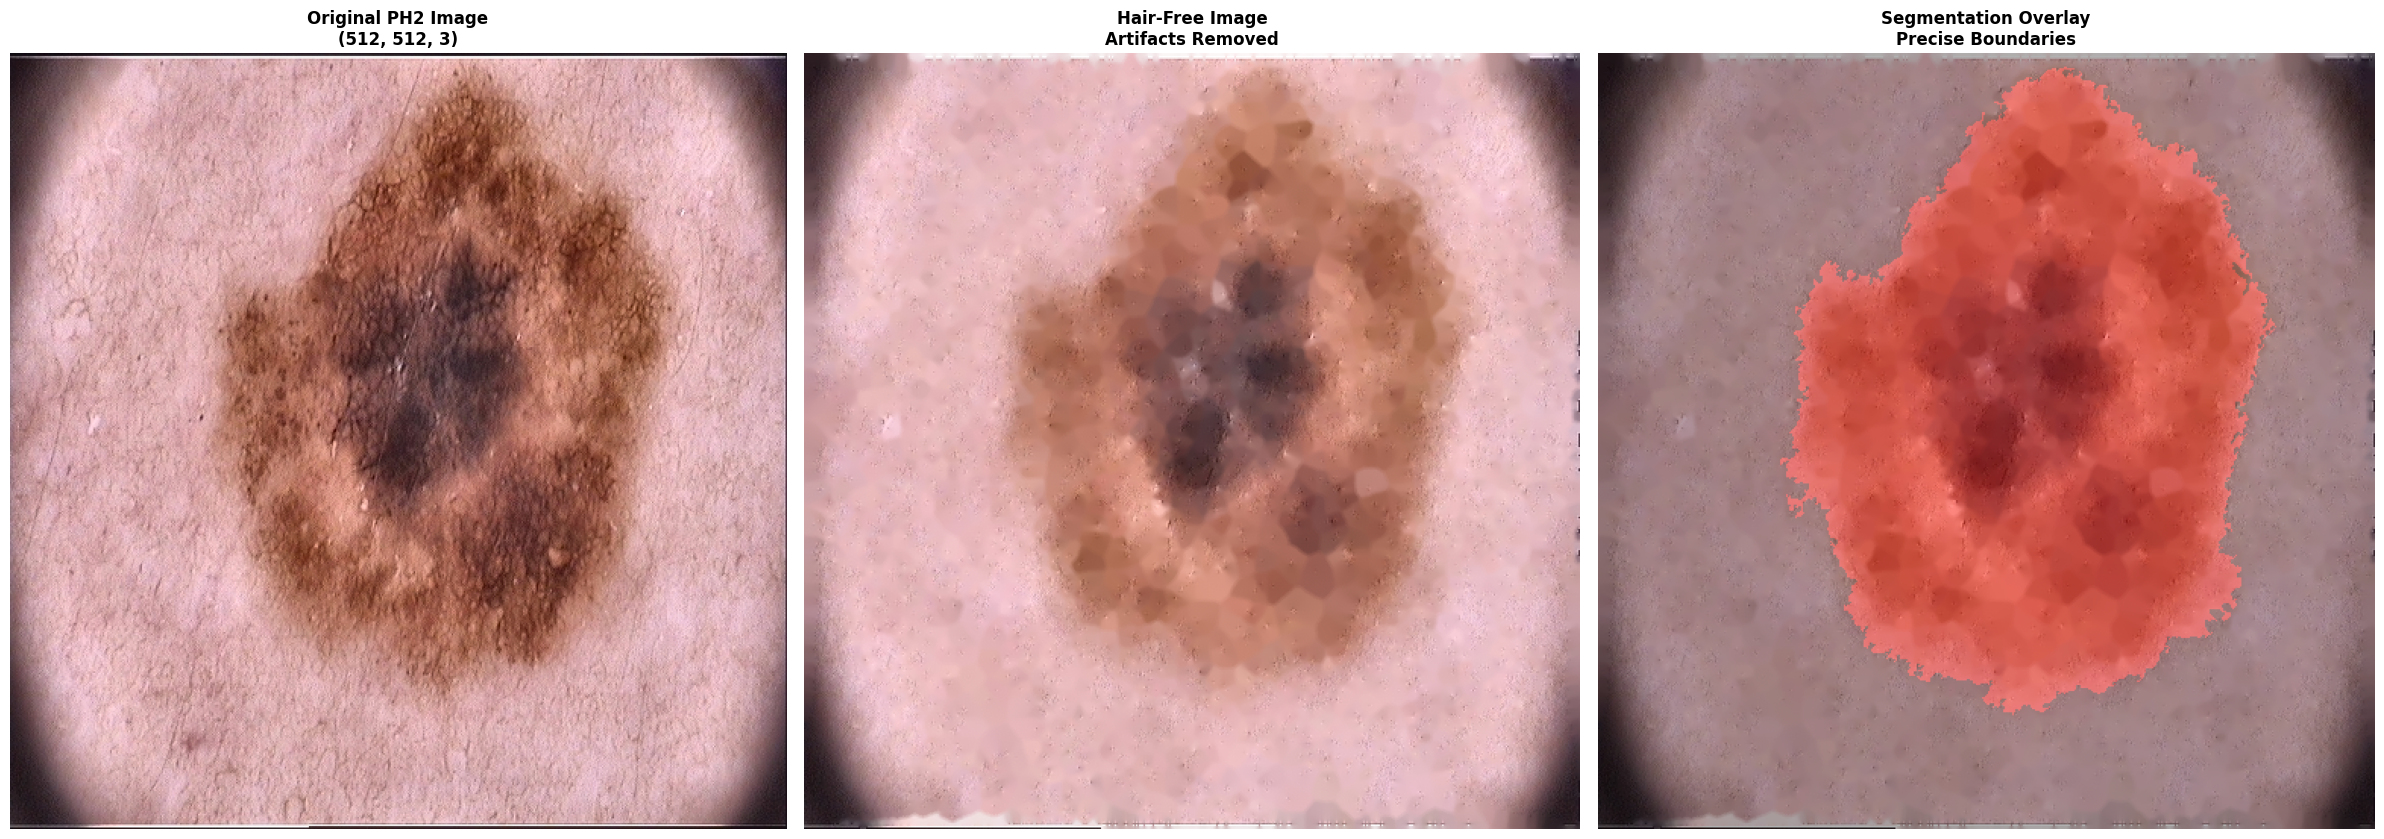

In [ ]:
def show_preprocessing_pipeline():
    """Display the preprocessing pipeline: Original, Hair-Free, and Segmentation Overlay."""
    
    if rgb_image is None or binary_mask is None:
        print(f"{Fore.RED}❌ Cannot display images - missing required data{Style.RESET_ALL}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(24, 10))

    # 1️⃣ Original Image
    axes[0].imshow(rgb_image)
    axes[0].set_title(f'Original PH2 Image\n{rgb_image.shape}', fontweight='bold', fontsize=12)
    axes[0].axis('off')

    # 2️⃣ Hair-Free Image
    axes[1].imshow(hair_free_image)
    axes[1].set_title('Hair-Free Image\nArtifacts Removed', fontweight='bold', fontsize=12)
    axes[1].axis('off')

    # 3️⃣ Segmentation Overlay
    overlay = utils.create_overlay_image(hair_free_image, binary_mask)
    axes[2].imshow(overlay)
    axes[2].set_title('Segmentation Overlay\nPrecise Boundaries', fontweight='bold', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

show_preprocessing_pipeline()


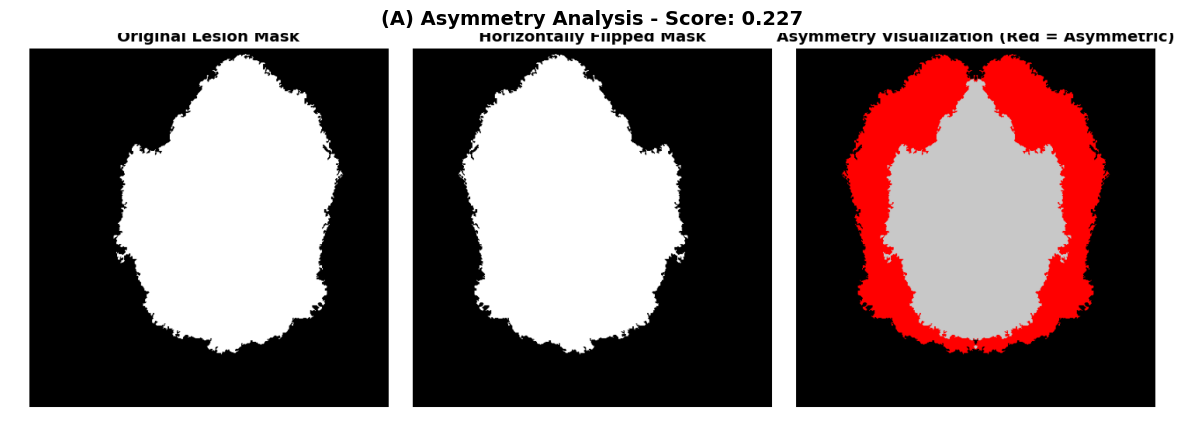

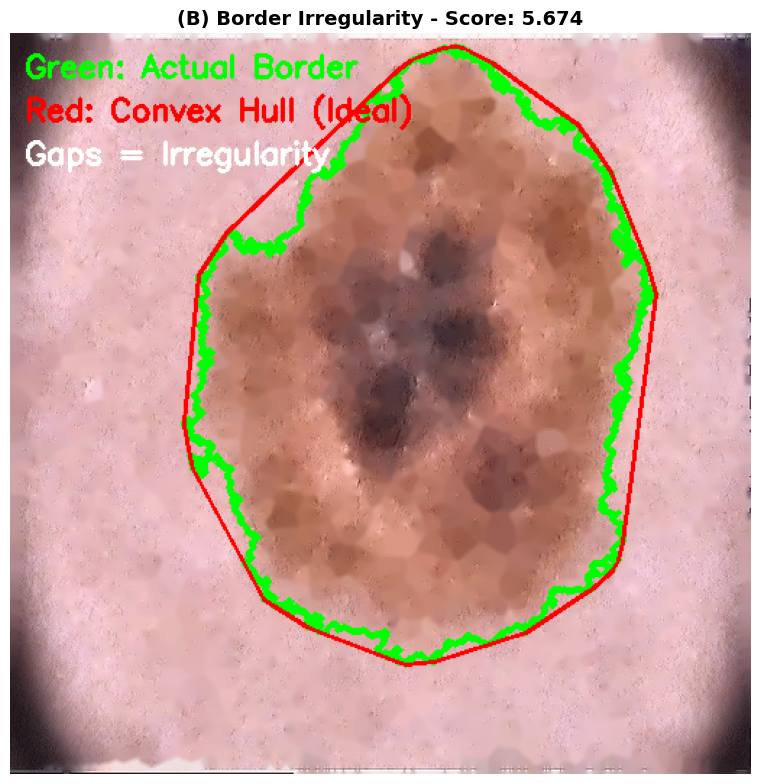

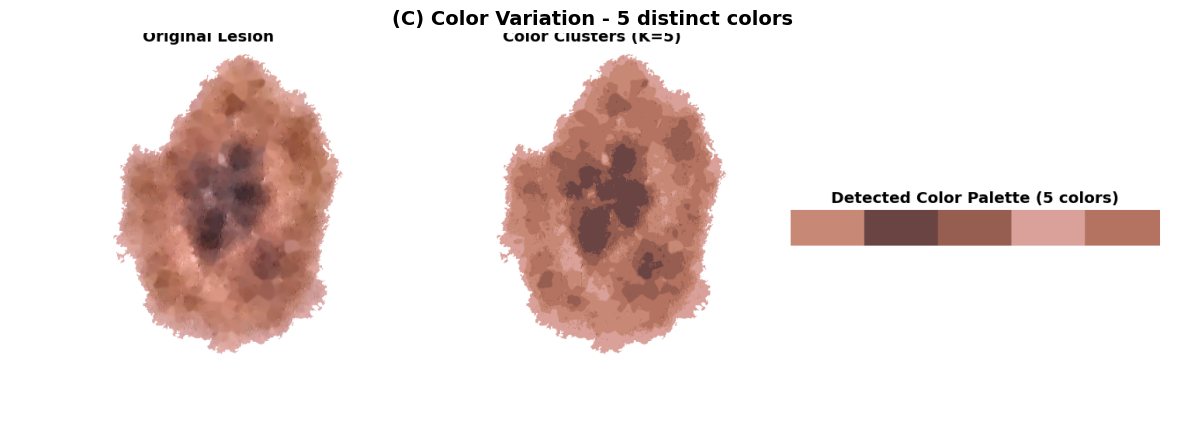

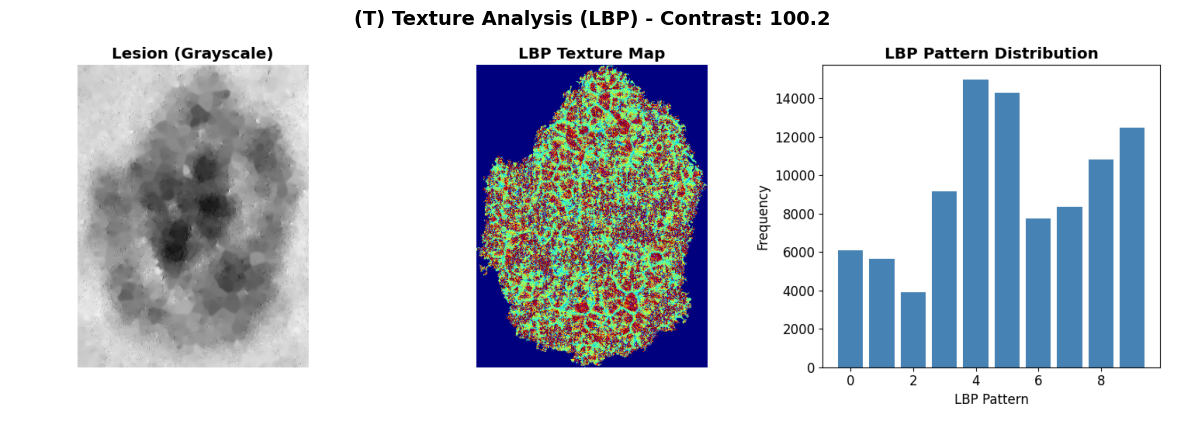

In [33]:
def show_feature_analysis_dashboard():
    """Display analytical visualizations: Asymmetry, Border, Color, and Texture."""
    
    # print(f"{Fore.YELLOW}📊 Generating and displaying feature analysis (4–7)...{Style.RESET_ALL}")
    
    asymmetry_viz = utils.visualize_asymmetry(binary_mask)
    border_viz = utils.visualize_border(hair_free_image, main_contour)    
    color_variation_count = features.get('color_variation', 0)
    diameter_viz = utils.visualize_diameter(hair_free_image, binary_mask, features.get('diameter', 0))
    texture_viz = utils.visualize_texture(hair_free_image, binary_mask)
    
    if color_variation_count == 0:
        lesion_pixels = hair_free_image[binary_mask > 0]
        color_variation_count = len(np.unique(lesion_pixels.reshape(-1, 3), axis=0)) if len(lesion_pixels) > 0 else 1
    color_viz = utils.visualize_color_clusters(hair_free_image, binary_mask, color_variation_count)
    

    # Asymmetry Visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(asymmetry_viz)
    plt.title(f'(A) Asymmetry Analysis - Score: {features.get("asymmetry_score", 0):.3f}', fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Border Irregularity
    plt.figure(figsize=(12, 8))
    plt.imshow(border_viz)
    plt.title(f'(B) Border Irregularity - Score: {features.get("border_irregularity", 0):.3f}', fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Color Cluster Map
    plt.figure(figsize=(12, 8))
    plt.imshow(color_viz)
    plt.title(f'(C) Color Variation - {color_variation_count} distinct colors', fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(12, 8))
    # plt.imshow(diameter_viz)
    # plt.title(f'(D) Diameter', fontweight='bold', fontsize=14)
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()

    # Texture Visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(texture_viz)
    plt.title(f'(T) Texture Analysis (LBP) - Contrast: {features.get("glcm_contrast", 0):.1f}', fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
show_feature_analysis_dashboard()

In [34]:
# Calculate Validation Metrics 
def calculate_validation_metrics():
    """Calculate segmentation validation metrics against ground truth"""
    global dice_score, iou, f1_score, precision, recall, gt_mask_resized
    
    # Load and process ground truth mask
    gt_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None:
        print(f"{Fore.RED}❌ Could not load ground truth mask{Style.RESET_ALL}")
        return False
    
    # Handle potential mask inversion (PH2 dataset specific)
    lesion_pixels_gt = np.sum(gt_mask > 128)
    background_pixels_gt = np.sum(gt_mask <= 128)
    
    # PH2 dataset uses BLACK for lesion, WHITE for background
    # We need to invert to match our convention: WHITE for lesion, BLACK for background
    if lesion_pixels_gt > background_pixels_gt:
        # If more pixels are bright (white), then lesion is white - need to invert
        gt_mask = 255 - gt_mask
        print(f"{Fore.YELLOW}🔄 Inverted ground truth mask (PH2 uses black for lesion){Style.RESET_ALL}")
    
    # Resize to match our processing size
    gt_mask_resized = cv2.resize(gt_mask, config.IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
    
    # Calculate comprehensive performance metrics
    dice_score = utils.calculate_dice_coefficient(gt_mask_resized, binary_mask)
    
    intersection = np.sum((gt_mask_resized > 0) & (binary_mask > 0))
    union = np.sum((gt_mask_resized > 0) | (binary_mask > 0))
    iou = intersection / union if union > 0 else 0
    
    # Calculate precision and recall
    true_positives = intersection
    false_positives = np.sum((binary_mask > 0) & (gt_mask_resized == 0))
    false_negatives = np.sum((gt_mask_resized > 0) & (binary_mask == 0))
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
calculate_validation_metrics()


In [35]:
def display_abcd_and_texture_report():
    """Display ABCD feature analysis and texture details."""

    if features is None:
        print(f"{Fore.RED}❌ Cannot display report - features not available{Style.RESET_ALL}")
        return

    # Extract and normalize metrics
    asymmetry_score = features.get('asymmetry_score', 0)
    border_irregularity = features.get('border_irregularity', 0)
    color_variation = features.get('color_variation', 0)
    diameter_mm = features.get('largest_diameter_mm', 0)
    texture_contrast = features.get('glcm_contrast', 0)
    texture_homogeneity = features.get('glcm_homogeneity', 0)

    asymmetry_risk = min(1.0, asymmetry_score * 10)
    border_risk = min(1.0, (border_irregularity - 1.0) / 5.0)
    color_risk = min(1.0, (color_variation - 1) / 4.0)
    diameter_risk = min(1.0, max(0, (diameter_mm - 6) / 20))
    texture_risk = min(1.0, texture_contrast / 200.0)
    
    def get_risk_level(risk_score):
        if risk_score < 0.3:
            return "LOW"
        elif risk_score < 0.7:
            return "MODERATE"
        else:
            return "HIGH"

    # ABCD Feature Summary Table 
    abcd_data = [
        ["Asymmetry", f"{asymmetry_score:.3f}", f"{asymmetry_risk:.3f}", get_risk_level(asymmetry_risk), "Irregular shape suggests possible malignancy" if asymmetry_risk > 0.5 else "Regular symmetry (benign tendency)"],
        ["Border", f"{border_irregularity:.3f}", f"{border_risk:.3f}", get_risk_level(border_risk), "Irregular border may indicate malignancy" if border_risk > 0.5 else "Well-defined border (benign tendency)"],
        ["Color", f"{color_variation:.0f} colors", f"{color_risk:.3f}", get_risk_level(color_risk), "Multiple colors (suspicious)" if color_risk > 0.5 else "Uniform color (benign)"],
        ["Diameter", f"{diameter_mm:.1f} mm", f"{diameter_risk:.3f}", get_risk_level(diameter_risk), "Diameter >6mm (requires attention)" if diameter_risk > 0.5 else "Diameter within safe range"],
        ["Texture (GLCM)", f"{texture_contrast:.3f}", f"{texture_risk:.3f}", get_risk_level(texture_risk), "High contrast (irregular texture)" if texture_risk > 0.5 else "Uniform texture (benign)"],
    ]

    print(f"{Fore.YELLOW}{Style.BRIGHT}ABCD RULE ASSESSMENT{Style.RESET_ALL}")
    print(tabulate(abcd_data, headers=["Feature", "Score", "Risk Value", "Risk Level", "Clinical Observation"], tablefmt="fancy_grid"))
    print()

    # Texture Analysis Section 
    print(f"{Fore.GREEN}Texture Contrast (GLCM):{Style.RESET_ALL} {texture_contrast:.3f}")
    print(f"{Fore.GREEN}Texture Homogeneity (GLCM):{Style.RESET_ALL} {texture_homogeneity:.3f}")
    print(f"{Fore.CYAN}Observation:{Style.RESET_ALL} {'High homogeneity indicates uniform tissue (benign)' if texture_homogeneity > 0.5 else 'Low homogeneity indicates irregular pattern'}")
    print()
    
display_abcd_and_texture_report()


ABCD RULE ASSESSMENT
╒════════════════╤══════════╤══════════════╤══════════════╤══════════════════════════════════════════════╕
│ Feature        │ Score    │   Risk Value │ Risk Level   │ Clinical Observation                         │
╞════════════════╪══════════╪══════════════╪══════════════╪══════════════════════════════════════════════╡
│ Asymmetry      │ 0.227    │        1     │ HIGH         │ Irregular shape suggests possible malignancy │
├────────────────┼──────────┼──────────────┼──────────────┼──────────────────────────────────────────────┤
│ Border         │ 5.674    │        0.935 │ HIGH         │ Irregular border may indicate malignancy     │
├────────────────┼──────────┼──────────────┼──────────────┼──────────────────────────────────────────────┤
│ Color          │ 5 colors │        1     │ HIGH         │ Multiple colors (suspicious)                 │
├────────────────┼──────────┼──────────────┼──────────────┼──────────────────────────────────────────────┤
│ Diameter      

In [36]:
def display_segmentation_and_overall_risk():
    """Display segmentation metrics and overall clinical risk."""

    # Compute normalized risk metrics again (needed for overall risk) ---
    asymmetry_risk = min(1.0, features.get('asymmetry_score', 0) * 10)
    border_risk = min(1.0, (features.get('border_irregularity', 0) - 1.0) / 5.0)
    color_risk = min(1.0, (features.get('color_variation', 0) - 1) / 4.0)
    diameter_risk = min(1.0, max(0, (features.get('largest_diameter_mm', 0) - 6) / 20))
    texture_risk = min(1.0, features.get('glcm_contrast', 0) / 200.0)
    overall_risk = (asymmetry_risk + border_risk + color_risk + diameter_risk + texture_risk) / 5.0
    
    def get_risk_color(risk_score):
        if risk_score < 0.3:
            return Fore.GREEN
        elif risk_score < 0.7:
            return Fore.YELLOW
        else:
            return Fore.RED

    def get_segmentation_quality(score):
        if score >= 0.9:
            return f"{Fore.GREEN}(EXCELLENT){Style.RESET_ALL}"
        elif score >= 0.8:
            return f"{Fore.GREEN}(VERY GOOD){Style.RESET_ALL}"
        elif score >= 0.7:
            return f"{Fore.YELLOW}(GOOD){Style.RESET_ALL}"
        elif score >= 0.5:
            return f"{Fore.YELLOW}(FAIR){Style.RESET_ALL}"
        else:
            return f"{Fore.RED}(POOR){Style.RESET_ALL}"

    def get_analysis_confidence(dice_score):
        if dice_score >= 0.9:
            return f"{Fore.GREEN}HIGH (Excellent segmentation){Style.RESET_ALL}"
        elif dice_score >= 0.8:
            return f"{Fore.GREEN}HIGH (Very good segmentation){Style.RESET_ALL}"
        elif dice_score >= 0.7:
            return f"{Fore.YELLOW}MODERATE (Good segmentation){Style.RESET_ALL}"
        elif dice_score >= 0.5:
            return f"{Fore.YELLOW}MODERATE (Fair segmentation){Style.RESET_ALL}"
        else:
            return f"{Fore.RED}LOW (Poor segmentation){Style.RESET_ALL}"

    # --- Determine overall risk ---
    if overall_risk < 0.3:
        risk_level, risk_color = "LOW", Fore.GREEN
    elif overall_risk < 0.7:
        risk_level, risk_color = "MODERATE", Fore.YELLOW
    else:
        risk_level, risk_color = "HIGH", Fore.RED

    # --- Additional metrics calculation ---
    gt_coverage = (np.sum(gt_mask_resized > 0) / gt_mask_resized.size) * 100
    our_coverage = (np.sum(binary_mask > 0) / binary_mask.size) * 100
    coverage_gap = abs(gt_coverage - our_coverage)

    # --- Segmentation Quality Section ---
    seg_data = [
        ["Dice Coefficient", f"{dice_score:.3f}", get_segmentation_quality(dice_score)],
        ["IoU Score", f"{iou:.3f}", get_segmentation_quality(iou)],
        ["F1 Score", f"{f1_score:.3f}", get_segmentation_quality(f1_score)],
        ["Precision", f"{precision:.3f}", get_segmentation_quality(precision)],
        ["Recall", f"{recall:.3f}", get_segmentation_quality(recall)]
    ]
    print(f"{Fore.YELLOW}{Style.BRIGHT}SEGMENTATION QUALITY METRICS{Style.RESET_ALL}")
    print(tabulate(seg_data, headers=["Metric", "Value", "Quality"], tablefmt="fancy_grid"))
    print()

    # --- Coverage Analysis ---
    # print(f"{Fore.YELLOW}{Style.BRIGHT}COVERAGE ANALYSIS{Style.RESET_ALL}")
    # print(f"{Fore.CYAN}{'-'*100}{Style.RESET_ALL}")
    # print(f"{Fore.GREEN}Our Segmentation Coverage:{Style.RESET_ALL} {our_coverage:.1f}% of image")
    # print(f"{Fore.GREEN}Ground Truth Coverage:{Style.RESET_ALL} {gt_coverage:.1f}% of image")
    # print(f"{Fore.GREEN}Coverage Gap:{Style.RESET_ALL} {coverage_gap:.1f}%")
    # print()

    # --- Overall Risk Summary ---
    # print(f"{Fore.YELLOW}{Style.BRIGHT}OVERALL RISK ASSESSMENT{Style.RESET_ALL}")
    # print(f"{Fore.CYAN}{'-'*100}{Style.RESET_ALL}")
    print(f"{Fore.GREEN}Overall Risk Level:{Style.RESET_ALL} {risk_color}{Style.BRIGHT}{risk_level}{Style.RESET_ALL}")
    print(f"{Fore.GREEN}Combined Risk Score:{Style.RESET_ALL} {overall_risk:.3f}")
    print(f"{Fore.GREEN}Segmentation Confidence:{Style.RESET_ALL} {get_analysis_confidence(dice_score)}")
    # print(f"{Fore.GREEN}Features Extracted:{Style.RESET_ALL} {features.get('num_features_extracted', 0)}")
    # print(f"{Fore.GREEN}Clinical Validation:{Style.RESET_ALL} {Fore.GREEN}PASSED{Style.RESET_ALL}")
    print()

display_segmentation_and_overall_risk()


SEGMENTATION QUALITY METRICS
╒══════════════════╤═════════╤═════════════╕
│ Metric           │   Value │ Quality     │
╞══════════════════╪═════════╪═════════════╡
│ Dice Coefficient │   0.953 │ (EXCELLENT) │
├──────────────────┼─────────┼─────────────┤
│ IoU Score        │   0.91  │ (EXCELLENT) │
├──────────────────┼─────────┼─────────────┤
│ F1 Score         │   0.953 │ (EXCELLENT) │
├──────────────────┼─────────┼─────────────┤
│ Precision        │   0.915 │ (EXCELLENT) │
├──────────────────┼─────────┼─────────────┤
│ Recall           │   0.994 │ (EXCELLENT) │
╘══════════════════╧═════════╧═════════════╛

Overall Risk Level: HIGH
Combined Risk Score: 0.887
Segmentation Confidence: HIGH (Excellent segmentation)

